## L_0 Deep_CCA Refinment And Expriments:

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 21.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import math
import torch.optim as optim
import torch
import numpy as np
import tqdm
import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### **StochasticGates**
The `StochasticGates` class implements a probabilistic gating mechanism to enforce sparsity in feature selection. It extends `torch.nn.Module` and learns a set of gating parameters, `\(\mu\)`, which determine the importance of each input feature. The gating mechanism follows:

$$
z = \text{clamp}(\mu + \sigma \cdot \mathcal{N}(0,1), 0, 1)
$$

where:
- $\mu$ is a learnable parameter initialized as ones or a provided value.
- $\sigma $ controls the noise level, enabling stochastic feature selection.

The forward pass applies element-wise gating:

$$
x' = x \odot z
$$

where $\odot$ denotes the Hadamard product.

Additional methods include:
- **`get_reg()`**: Computes the regularization term:

$$
\lambda \sum \frac{1 + \text{erf}(\frac{\mu}{\sigma \sqrt{2}})}{2}
$$

which promotes sparsity.
- **`get_gates()`**: Returns clamped gate values $\mu$ .
- **`get_eta_estimate()`**: Provides an estimate of expected gate activation probability:

$$
\frac{1 + \text{erf}(\frac{\mu}{\sigma \sqrt{2}})}{2}
$$

This gating mechanism ensures that only the most relevant features contribute to the final representation while maintaining differentiability for optimization.

In [ ]:

class StochasticGates(nn.Module):
    def __init__(self, size, sigma, lam, gate_init=None):
        super().__init__()
        self.size = size
        if gate_init is None:
            mus = 1.0 * torch.ones(size)
        else:
            mus = torch.from_numpy(gate_init)
        self.mus = nn.Parameter(mus, requires_grad=True)
        self.sigma = sigma
        self.lam = lam

    def forward(self, x):
        gaussian = self.sigma * torch.randn(self.mus.size()) * self.training
        shifted_gaussian = self.mus + gaussian.to(x.device)
        z = torch.clamp(shifted_gaussian, 0.0, 1.0)
        new_x = x * z
        return new_x

    def get_reg(self):
        return self.lam * torch.sum((1 + torch.erf((self.mus / self.sigma) / math.sqrt(2))) / 2)

    def get_gates(self):
        return torch.clamp(self.mus, 0.0, 1.0)

    def get_eta_estimate(self):
            """
            Returns the gating probabilities (i.e., 'z' in [0,1]).
            Note: This is *not* the final canonical vector if you have
            additional learned weights to multiply by, or if you need L2 norm.
            """
            eta = (1 + torch.erf((self.mus / self.sigma) / math.sqrt(2))) / 2
            return eta



### **SDCCA CLASS**

The `SDCCA` class implements Sparse Deep Canonical Correlation Analysis (SDCCA) with stochastic gating to enforce sparsity in feature selection. It extends `torch.nn.Module` and consists of two gated transformation pipelines for input modalities `X` and `Y`. Each pipeline includes:
1. `StochasticGates` for probabilistic feature selection.
2. A transformation function (`f` for `X`, `g` for `Y`).

The `forward` method applies these transformations to the inputs, returning sparse representations of `X` and `Y`. This structure ensures efficient feature selection and enhances model interpretability.
*italicized text*

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

class SDCCA(nn.Module):
    def __init__(self, x_size, f, lamx, sigmax,
                       y_size, g, lamy, sigmay):
        super().__init__()
        self.gated_f = nn.Sequential(
            StochasticGates(x_size, sigmax, lamx),
            f)
        self.gated_g = nn.Sequential(
            StochasticGates(y_size, sigmay, lamy),
            g)

    def forward(self, X, Y):
        return self.gated_f(X), self.gated_g(Y)

    def get_reg(self):
        # Regularization from both gate modules
        return self.gated_f[0].get_reg().mean() + self.gated_g[0].get_reg().mean()

    def get_gates(self):
        # Retrieve current gate values from both modalities
        return self.gated_f[0].get_gates(), self.gated_g[0].get_gates()

    def get_function_parameters(self):
        # Return learnable parameters of the function parts f and g.
        params = list()
        for function in [self.gated_f, self.gated_g]:
            params += list(function[1].parameters())
        return params

    def get_gates_parameters(self):
        # Return learnable parameters of the stochastic gates.
        params = list()
        for function in [self.gated_f, self.gated_g]:
            params += list(function[0].parameters())
        return params

    def get_eta_estimate(self):
        # Retrieve estimated eta values for each modality.
        eta_x = self.gated_f[0].get_eta_estimate()
        eta_y = self.gated_g[0].get_eta_estimate()
        return eta_x, eta_y

    def plot_gradients(self):
        """
        Plots histograms of the gradient norms for gate parameters and function parameters.
        Call this method after loss.backward() and before the optimizer steps.
        """
        # Collect gradient norms for gate parameters.
        gate_grads = []
        for param in self.get_gates_parameters():
            if param.grad is not None:
                grad_norm = param.grad.detach().cpu().norm().item()
                gate_grads.append(grad_norm)

        # Collect gradient norms for function parameters.
        func_grads = []
        for param in self.get_function_parameters():
            if param.grad is not None:
                grad_norm = param.grad.detach().cpu().norm().item()
                func_grads.append(grad_norm)

        avg_gate_grad = np.mean(gate_grads) if gate_grads else 0
        avg_func_grad = np.mean(func_grads) if func_grads else 0

        print(f"Avg Gate Gradients: {avg_gate_grad:.4f}, Avg Function Gradients: {avg_func_grad:.4f}")



### **Utilities Tools**
### Overview

This module provides essential functions for generating synthetic data, normalizing tensors, visualizing gating mechanisms, and computing estimation errors in Sparse Canonical Correlation Analysis (SCCA).

### Data Generation (`gen_data`)

The function `gen_data` generates synthetic paired datasets $(X, Y)$ with a predefined correlation structure. It constructs covariance matrices $\Sigma_x$ and $\Sigma_y$, which can follow different structures:

- **Identity covariance**: $\Sigma_x = I_p$, $\Sigma_y = I_q$
- **Toeplitz covariance**: $\Sigma_x[i, j] = 0.9^{|i - j|}$
- **Sparse inverse covariance**: Uses a structured inverse covariance matrix $\Sigma_0$

The generated data follows a multivariate normal distribution:

$$
(X, Y) \sim \mathcal{N} \left( 0, \Sigma \right)
$$

where $\Sigma$ is the block covariance matrix:

$$
\Sigma =
\begin{bmatrix}
\Sigma_x & \Sigma_{xy} \\
\Sigma_{yx} & \Sigma_y
\end{bmatrix}
$$

The cross-covariance matrix $\Sigma_{xy}$ is constructed as:

$$
\Sigma_{xy} = \rho \cdot \Sigma_x \cdot u v^T \cdot \Sigma_y
$$

where:
- $\rho$ controls the correlation strength,
- $u$ and $v$ are sparse canonical vectors with $k$ nonzero entries,
- $\Sigma_{yx} = \Sigma_{xy}^T$ ensures symmetry.

The function ensures positive definiteness of $\Sigma$ before drawing samples from $\mathcal{N}(0, \Sigma)$.

### L2 Normalization (`L2Norm`)

This class normalizes input tensors along the last dimension:

$$
x' = \frac{x}{\|x\|}
$$

ensuring unit-norm feature vectors.

### Gate Visualization (`plot_gates`)

The function `plot_gates` visualizes learned gating values alongside ground truth canonical vectors. It plots:
- $x$-gates (compared to true canonical vector $u$)
- $y$-gates (compared to true canonical vector $v$)

This helps assess whether the model selects relevant features.

### Canonical Estimation Error (`canonical_error`)

This function computes the estimation error between a true and estimated canonical vector:

$$
\text{error} = 2 \left( 1 - \left| \phi_{\text{true}}^T \phi_{\text{est}} \right| \right)
$$

which measures the deviation in alignment between estimated and true canonical directions.

### Estimation Error Computation (`compute_estimation_errors`)

This function evaluates errors for both canonical vectors:

$$
\text{error}_\phi = \text{canonical\_error}(\phi_{\text{true}}, \phi_{\text{est}})
$$

$$
\text{error}_\eta = \text{canonical\_error}(\eta_{\text{true}}, \eta_{\text{est}})
$$

It returns the estimation errors for further analysis.

---

This module plays a crucial role in generating synthetic data, normalizing representations, evaluating gate performance, and quantifying estimation accuracy.


In [ ]:
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt


def gen_data(n=400, p=1600, q=1600, rho=0.9, flag=0, fac=1):
    np.random.seed(123)
    Sigma_x = 1 * np.eye(p)
    Sigma_y = 1 * np.eye(q)
    Sigma_0 = 1 * np.eye(p)
    if flag == 1:
        for i in range(p):
            for j in range(p):
                Sigma_x[i, j] = 0.9 ** (abs(i - j))
    elif flag == 2:
        for i in range(p):
            for j in range(p):
                if np.abs(i - j) == 1:
                    Sigma_0[i, j] = 0.5
                elif np.abs(i - j) == 2:
                    Sigma_0[i, j] = 0.4
        Sigma_1 = np.copy(np.linalg.inv(Sigma_0))
        Sigma_x = np.copy(Sigma_1)
        for i in range(p):
            for j in range(p):
                Sigma_x[i, j] = Sigma_1[i, j] / (np.sqrt(Sigma_1[i, i] * Sigma_1[j, j]))

    Sigma_y = Sigma_x

    k = 5
    not_valid = True
    while not_valid:
        u = np.zeros((p, 1))
        v = np.zeros((q, 1))
        ind1 = np.random.choice(np.arange(p), k)
        ind2 = np.random.choice(np.arange(q), k)
        u[ind1] = fac / np.sqrt(k)
        v[ind2] = fac / np.sqrt(k)
        Sigma_xy = rho * Sigma_x @ u @ v.T @ Sigma_y
        Sigma1 = np.hstack((Sigma_x, Sigma_xy))
        Sigma2 = np.hstack((Sigma_xy.T, Sigma_y))
        Sigma = np.vstack((Sigma1, Sigma2))
        #    pos_def=is_pos_def(Sigma)
        #   if pos_def:
        not_valid = False
        if sum(u != 0) != k or sum(v != 0) != k:
            print('problems with u or v')
            not_valid = True
        try:
            xy = np.random.multivariate_normal(np.zeros(Sigma.shape[0]), Sigma, n, check_valid='raise')
        except:
            print('Cov not valid')
            not_valid = True

    x = xy[:, :p]
    y = xy[:, p:]
    return x, y, u, v, Sigma_xy


class L2Norm(nn.Module):
    def __init__(self):
        super(L2Norm, self).__init__()

    def forward(self, x):
        return nn.functional.normalize(x, dim=-1)


def plot_gates(net, name, u, v):
    g_x, g_y = net.get_gates()

    #print("Raw gate values for x:", g_x)
    #print("Raw gate values for y:", g_y)

    g_x = g_x.cpu().detach().numpy().T
    g_y = g_y.cpu().detach().numpy().T

    plt.subplot(2, 1, 1)
    plt.stem(u, basefmt=" ", markerfmt='D')
    plt.stem(g_x, basefmt=" ", linefmt='r')
    plt.title(f'x gates')

    plt.subplot(2, 1, 2)
    plt.stem(v, basefmt=" ", markerfmt='D')
    plt.stem(g_y, basefmt=" ", linefmt='r')
    plt.title(f'y gates')

    plt.suptitle(f'{name}')
    plt.show()
    plt.close()

def canonical_error(true_vec, est_vec):
    """
    Computes the canonical estimation error metric as used in the paper.

    Parameters:
        true_vec (np.ndarray): Ground truth canonical vector.
        est_vec (np.ndarray): Estimated canonical vector.

    Returns:
        float: Estimation error.
    """
    return 2 * (1 - np.abs(np.dot(true_vec.T, est_vec)))


def compute_estimation_errors(true_phi, est_phi, true_eta, est_eta):
    """
    Computes the estimation errors for the canonical vectors of both views.

    Parameters:
        true_phi (np.ndarray): Ground truth canonical vector for view X.
        est_phi (np.ndarray): Estimated canonical vector for view X.
        true_eta (np.ndarray): Ground truth canonical vector for view Y.
        est_eta (np.ndarray): Estimated canonical vector for view Y.

    Returns:
        tuple: (error_phi, error_eta) corresponding to each view.
    """
    error_phi = canonical_error(true_phi, est_phi)
    error_eta = canonical_error(true_eta, est_eta)

    return error_phi, error_eta

### Main

The `main()` function initializes and trains a Sparse Canonical Correlation Analysis (SCCA) model using stochastic gating. It generates synthetic data, optimizes the gating and transformation functions, and evaluates estimation errors.

### Model Architecture

### Overview

This module defines functions for creating and training a **Sparse Deep Canonical Correlation Analysis (SDCCA)** model. It includes:
- **`create_networks()`**: Constructs the SDCCA model with neural network transformations.
- **`train()`**: Optimizes the model using two separate optimizers for function parameters and gating parameters.
- **`simple_train()`**: A simplified training routine using a single optimizer.

---

### Model Creation (`create_networks`)

The function `create_networks()` initializes the SDCCA model with two neural networks, $f$ and $g$, each applied to one of the input modalities ($X$ and $Y$). The architecture consists of:
- **Three fully connected layers**:
  - Input dimension: `size`
  - Hidden layers: 100 neurons each with ReLU activation
  - Output dimension: 10 (final embedding space)
- **L2 Normalization**: Ensures output vectors have unit norm.

The SDCCA model is created with:
$$
\text{net} = \text{SDCCA}(\text{size}, f, \lambda_x, \sigma_x, \text{size}, g, \lambda_y, \sigma_y)
$$
where $\lambda_x, \lambda_y$ control sparsity and $\sigma_x, \sigma_y$ define gating noise levels.

---

### Training Function (`train`)

The function `train()` optimizes both **gating parameters** and **function parameters** using separate optimizers:
1. **Gating parameters** (`gates_optim`): Updated every $K$ steps.
2. **Function parameters** (`func_optim`): Updated at every iteration.

#### Training Steps:
1. **Forward Pass**: Compute embeddings $x_{\text{emb}}$ and $y_{\text{emb}}$:
   $$
   x_{\text{emb}}, y_{\text{emb}} = \text{net}(x, y)
   $$
2. **Compute Loss**:
   - **Negative Correlation Loss**: Measures alignment between projected embeddings.
   - **Regularization Term**: Enforces sparsity.
   $$
   \text{loss} = \text{neg\_corr} + \text{reg}
   $$
3. **Backward Pass**:
   - Compute gradients and update function parameters.
   - Update gating parameters only if $k = 0$.

This ensures efficient optimization while maintaining sparsity control.

---

### Simplified Training Function (`simple_train`)

The function `simple_train()` performs the same training steps as `train()` but uses a **single optimizer** for both functions and gates. This variant is useful when fine-grained control over optimization is not required.

---

### Summary

- `create_networks()` constructs a **deep neural SDCCA model** with separate transformations for each modality.
- `train()` implements a **two-optimizer training scheme**, balancing function learning and feature selection.
- `simple_train()` provides a **basic training alternative** using a single optimizer.

This setup enables efficient training of SDCCA models with **structured sparsity and feature selection**.


In [ ]:
def create_networks(lamx, sigmax, lamy, sigmay, size,hidden_layer_sizes):

    # Helper function to build a Sequential network
    def build_network(input_size, layer_sizes):
        layers = []
        prev_size = input_size

        for hidden_size in layer_sizes:
            layers.append(nn.Linear(prev_size, hidden_size, bias=False))
            layers.append(nn.ReLU())
            prev_size = hidden_size

        # Remove last ReLU for the final hidden layer
        layers = layers[:-1]
        layers.append(L2Norm())

        return nn.Sequential(*layers)

    # Create networks f and g with customizable layers
    f = build_network(size, hidden_layer_sizes)
    g = build_network(size, hidden_layer_sizes)

    net = SDCCA(size, f, lamx, sigmax,
                size, g, lamy, sigmay)

    return net


def train(net, criterion, x, y, gates_optim, func_optim, k):
    net.train()
    if k == 0:
        gates_optim.zero_grad()
    func_optim.zero_grad()

    x_emb, y_emb = net(x, y)
    neg_corr = criterion(x_emb, y_emb)
    reg = net.get_reg()
    loss = neg_corr + reg
    loss.backward()

    # Optionally, call the gradient plotting method here for debugging:
    # net.plot_gradients()

    func_optim.step()
    if k == 0:
        gates_optim.step()

    return neg_corr.item(), reg.item()


def simple_train(net, criterion, x, y, optimizer):
    net.train()
    optimizer.zero_grad()

    x_emb, y_emb = net(x, y)
    neg_corr = criterion(x_emb, y_emb)
    reg = net.get_reg()
    loss = neg_corr + reg
    loss.backward()

    optimizer.step()


In [ ]:
import numpy as np
import torch

def init_gate_params_from_crosscov(
    X: np.ndarray,
    Y: np.ndarray,
    percentile_cov: float = 90.0,
    percentile_vec: float = 90.0
):
    # 1) Compute cross-covariance
    N, Dx = X.shape
    _, Dy = Y.shape
    C_xy = (X.T @ Y) / (N - 1)

    # 2) Threshold the cross-cov
    abs_cxy = np.abs(C_xy).flatten()
    cutoff_cov = np.percentile(abs_cxy, percentile_cov)
    C_bar = np.where(np.abs(C_xy) > cutoff_cov, C_xy, 0.0)

    # 3) SVD on thresholded matrix
    U, S, Vt = np.linalg.svd(C_bar, full_matrices=False)
    u = U[:, 0]   # shape (Dx,)
    v = Vt[0, :]  # shape (Dy,)

    # 4) Threshold the absolute values of u, v
    abs_u = np.abs(u)
    abs_v = np.abs(v)
    cutoff_u = np.percentile(abs_u, percentile_vec)
    cutoff_v = np.percentile(abs_v, percentile_vec)
    abs_u[abs_u < cutoff_u] = 0.0
    abs_v[abs_v < cutoff_v] = 0.0

    # 5) Construct mu_x, mu_y
    mu_x = 0.5 + abs_u
    mu_y = 0.5 + abs_v
    mu_x = np.clip(mu_x, 0.0, 1.0)
    mu_y = np.clip(mu_y, 0.0, 1.0)

    return mu_x, mu_y


## Loss Function

### Summary

This module provides two essential components for **Sparse Canonical Correlation Analysis (SCCA)**:

1. **Covariance Computation (`cov`)**  
   - Computes the sample covariance between two datasets.
   - Formula:
     $$
     \text{cov}(X, Y) = \frac{(Y - \bar{Y})^T (X - \bar{X})}{N - 1}
     $$
   - Ensures proper statistical estimation of relationships between two feature sets.

2. **Negative Correlation Loss (`NegCorr`)**  
   - Implements a loss function to **maximize canonical correlation**.
   - Computes covariance matrices:
     - $C_{yy} = \text{cov}(Y, Y)$
     - $C_{yx} = \text{cov}(Y, X)$
     - $C_{xx} = \text{cov}(X, X)$
   - Regularizes diagonal elements to avoid singularity:
     $$
     C_{yy} = C_{yy} + \epsilon I, \quad C_{xx} = C_{xx} + \epsilon I
     $$
   - Computes the **correlation matrix**:
     $$
     M = C_{yy}^{-1} C_{yx} C_{xx}^{-1} C_{yx}^T
     $$
   - Returns the **negative trace** of $M$ as the loss:
     $$
    L = -\text{Tr}M
     $$

### Key Takeaways
- **`cov()`** provides an efficient way to compute empirical covariance.
- **`NegCorr`** ensures that learned feature representations are **highly correlated**.
- **Regularization** prevents numerical instability when inverting covariance matrices.

This loss function is fundamental in **SCCA models**, ensuring that feature embeddings capture **maximally correlated** information across different modalities.


In [ ]:
def cov(x, y):
    x_bar = x - x.mean(axis=0)
    y_bar = y - y.mean(axis=0)
    N = x_bar.shape[0]
    return (y_bar.T @ x_bar).T / (N - 1)


class NegCorr(nn.Module):
    def __init__(self, device, eps=1e-5):
        super(NegCorr, self).__init__()
        self.device = device
        self.eps = eps

    def forward(self, x, y):
        C_yy = cov(y, y)
        C_yx = cov(y, x)
        C_xx = cov(x, x)

        C_yy = C_yy + torch.eye(C_yy.shape[0], device=self.device) * self.eps
        C_xx = C_xx + torch.eye(C_xx.shape[0], device=self.device) * self.eps

        M = torch.linalg.multi_dot([torch.inverse(C_yy),
                                    C_yx,
                                    torch.inverse(C_xx),
                                    C_yx.T])
        return -torch.trace(M)


In [ ]:
import optuna
import torch
import torch.optim as optim
import numpy as np
import os

# If needed: from your_code import gen_data, create_networks, train, NegCorr

def objective(trial):
    """
    Objective function for Optuna to optimize the final error of our l0-based CCA.
    We unify lamx=lamy and sigmax=sigmay.
    """
    # ====== Hyperparameter Sampling (log-scale) ======
    lam   = trial.suggest_float("lam",    5e-4,  100,   log=True)
    sigma = trial.suggest_float("sigma",  1e-2,  0.5,   log=True)

    # Learning rates for gates and function (still log-scale, wide range)
    lr_gates = trial.suggest_float("lr_gates", 1e-5, 1e-1, log=True)
    lr_func  = trial.suggest_float("lr_func",  1e-5, 1e-1, log=True)

    # Frequency of gating vs function updates
    K = trial.suggest_int("K", 1, 10)

    # ====== Data Generation ======
    samples = 400
    size    = 800
    x_data, y_data, u_true, v_true, _ = gen_data(samples, size, size)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    x = torch.tensor(x_data, device=device, dtype=torch.float32)
    y = torch.tensor(y_data, device=device, dtype=torch.float32)

    # ====== Create Network ======
    net = create_networks(
        lamx = lam,
        lamy = lam,      # unify lamx and lamy
        sigmax = sigma,
        sigmay = sigma,  # unify sigmax and sigmay
        size = size,
        hidden_layer_sizes = [1600, 1600, 400]
    ).to(device)

    criterion = NegCorr(device)
    gates_optimizer = optim.Adam(net.get_gates_parameters(), lr=lr_gates)
    funcs_optimizer = optim.Adam(net.get_function_parameters(), lr=lr_func)

    # We use fewer epochs here so each trial is faster
    max_epochs = 10000
    for epoch in range(max_epochs):
        neg_corr, reg = train(
            net,
            criterion,
            x,
            y,
            gates_optimizer,
            funcs_optimizer,
            (epoch + 1) % K
        )
        # Optionally: trial.report(...)
        # if trial.should_prune():
        #     raise optuna.TrialPruned()

    # ====== Evaluate Final Error ======
    eta_x_est, eta_y_est = net.get_eta_estimate()
    eta_x_est = eta_x_est.detach().cpu().numpy().flatten()
    eta_y_est = eta_y_est.detach().cpu().numpy().flatten()

    # Normalize ground-truth
    u_norm = u_true / (np.linalg.norm(u_true) + 1e-12)
    v_norm = v_true / (np.linalg.norm(v_true) + 1e-12)

    # Also normalize estimates to ensure dot products are in [-1,1]
    eta_x_norm = eta_x_est / (np.linalg.norm(eta_x_est) + 1e-12)
    eta_y_norm = eta_y_est / (np.linalg.norm(eta_y_est) + 1e-12)

    dot_x = np.dot(u_norm.flatten(), eta_x_norm)
    dot_y = np.dot(v_norm.flatten(), eta_y_norm)

    # Nonnegative error in [0,2] for each view
    error_x = 2.0 * (1.0 - abs(dot_x))
    error_y = 2.0 * (1.0 - abs(dot_y))
    final_error = (error_x + error_y) / 2.0

    return final_error

def run_optuna_search(n_trials=20):
    """
    Create (or load) an Optuna study from a SQLite file on Drive,
    then run multiple trials to find hyperparams that minimize the final error.
    """
    # Example: Storing or reloading from 'my_study.db' on Google Drive
    db_path = "/content/drive/MyDrive/my_study.db"
    study_name = "my_l0_cca_study"

    # Create or load if exists:
    study = optuna.create_study(
        study_name=study_name,
        storage=f"sqlite:///{db_path}",
        load_if_exists=True,       # resume if it already exists
        direction="minimize"
    )

    study.optimize(objective, n_trials=n_trials)

    print("=== Study Summary ===")
    print(f"Best value (lowest error): {study.best_value}")
    print("Best hyperparams:")
    for k, v in study.best_params.items():
        print(f"  {k}: {v}")

    return study

if __name__ == "__main__":
    study = run_optuna_search(n_trials=300)


[I 2025-03-25 00:35:30,400] Using an existing study with name 'my_l0_cca_study' instead of creating a new one.
[I 2025-03-25 00:37:08,882] Trial 200 finished with value: 1.8340756079546054 and parameters: {'lam': 10.058799344464239, 'sigma': 0.15267304604505802, 'lr_gates': 0.07150655406730935, 'lr_func': 0.05396604535943831, 'K': 8}. Best is trial 154 with value: 1.7927385094442645.
[I 2025-03-25 00:38:48,336] Trial 201 finished with value: 1.8408381454269422 and parameters: {'lam': 9.139403327717808, 'sigma': 0.1574701364909486, 'lr_gates': 0.0992724140685816, 'lr_func': 3.1471954888858466e-05, 'K': 8}. Best is trial 154 with value: 1.7927385094442645.
[I 2025-03-25 00:40:26,314] Trial 202 finished with value: 1.8367544117581667 and parameters: {'lam': 11.814128379271041, 'sigma': 0.13807367058876024, 'lr_gates': 0.07622988700271907, 'lr_func': 0.09986870497440979, 'K': 8}. Best is trial 154 with value: 1.7927385094442645.
[I 2025-03-25 00:42:04,450] Trial 203 finished with value: 1.

=== Study Summary ===
Best value (lowest error): 1.7122714298444563
Best hyperparams:
  lam: 31.730907421874115
  sigma: 0.2531494072195986
  lr_gates: 0.0539662785479417
  lr_func: 0.04226748577329549
  K: 7


=== Study Summary ===
Best value (lowest error): 1.8239748220432017
Best hyperparams:
  lam: 18.572825653334384
  sigma: 0.15282286895619035
  lr_gates: 0.07664367947558408
  lr_func: 0.01857446050496441
  K: 9

Epoch[100/10000]: corr: 333.9128, reg: 57321.4609
Epoch[200/10000]: corr: 312.0119, reg: 54145.1445
Epoch[300/10000]: corr: 235.0033, reg: 42296.5547
Epoch[400/10000]: corr: 196.9344, reg: 33277.4688
Epoch[500/10000]: corr: 191.1739, reg: 30639.3789
Epoch[600/10000]: corr: 182.6788, reg: 29799.1270
Epoch[700/10000]: corr: 187.2905, reg: 29447.9805
Epoch[800/10000]: corr: 87.3598, reg: 29271.8496
Epoch[900/10000]: corr: 119.1047, reg: 29173.6973
Epoch[1000/10000]: corr: 0.7166, reg: 29106.6719


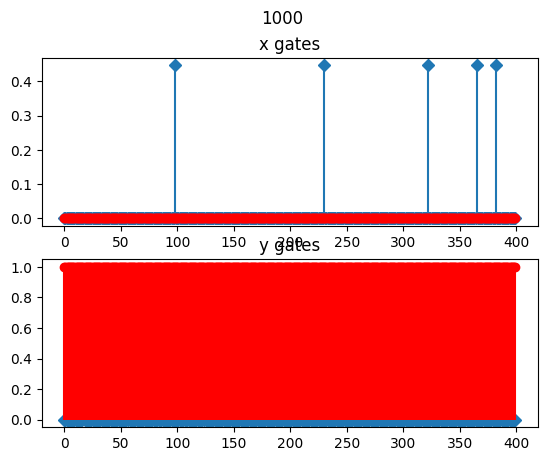

Epoch[1100/10000]: corr: 73.7333, reg: 29064.0273
Epoch[1200/10000]: corr: 0.6708, reg: 29030.2910
Epoch[1300/10000]: corr: 27.8766, reg: 29005.2852
Epoch[1400/10000]: corr: 28.3948, reg: 28985.9414
Epoch[1500/10000]: corr: 29.7609, reg: 28969.2168
Epoch[1600/10000]: corr: 28.2757, reg: 28955.4883
Epoch[1700/10000]: corr: 117.9712, reg: 28944.2324
Epoch[1800/10000]: corr: 27.2741, reg: 28934.7676
Epoch[1900/10000]: corr: 17.0539, reg: 28925.5254
Epoch[2000/10000]: corr: 26.8149, reg: 28917.1621


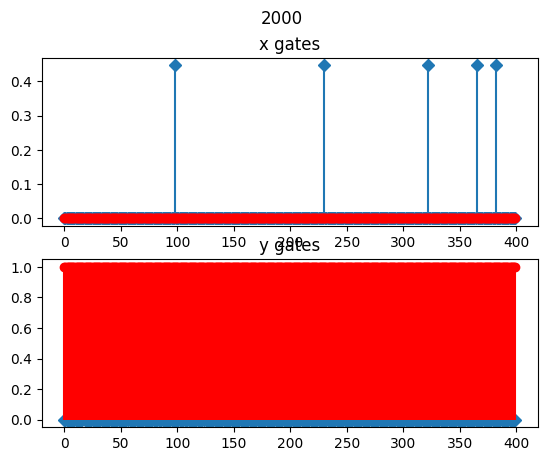

Epoch[2100/10000]: corr: 0.8306, reg: 28910.1016
Epoch[2200/10000]: corr: 81.4501, reg: 28903.7031
Epoch[2300/10000]: corr: 26.6133, reg: 28898.9355
Epoch[2400/10000]: corr: 26.1714, reg: 28893.8555
Epoch[2500/10000]: corr: 25.3736, reg: 28889.8926
Epoch[2600/10000]: corr: 0.0000, reg: 28886.7773
Epoch[2700/10000]: corr: 27.4621, reg: 28883.2637
Epoch[2800/10000]: corr: 0.6911, reg: 28879.7344
Epoch[2900/10000]: corr: 0.0000, reg: 28876.4062
Epoch[3000/10000]: corr: 0.9294, reg: 28873.3672


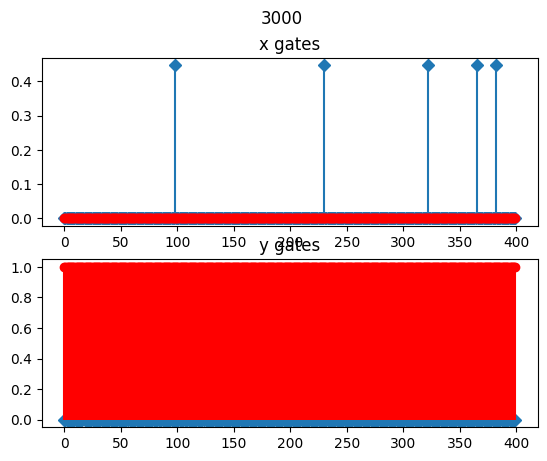

Epoch[3100/10000]: corr: 0.8033, reg: 28870.7773
Epoch[3200/10000]: corr: 23.3342, reg: 28868.3535
Epoch[3300/10000]: corr: 0.0000, reg: 28866.3965
Epoch[3400/10000]: corr: 16.2339, reg: 28864.4980
Epoch[3500/10000]: corr: 0.6773, reg: 28862.5137
Epoch[3600/10000]: corr: 0.0000, reg: 28860.5938
Epoch[3700/10000]: corr: 0.0000, reg: 28858.9199
Epoch[3800/10000]: corr: 0.7665, reg: 28857.2910
Epoch[3900/10000]: corr: 0.0000, reg: 28855.9219
Epoch[4000/10000]: corr: 0.0000, reg: 28854.5156


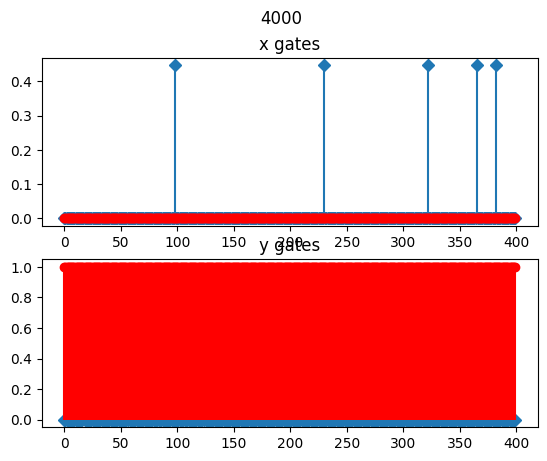

Epoch[4100/10000]: corr: 0.9318, reg: 28853.4707
Epoch[4200/10000]: corr: 0.0000, reg: 28852.2578
Epoch[4300/10000]: corr: 0.0000, reg: 28851.0586
Epoch[4400/10000]: corr: 0.0000, reg: 28850.0273
Epoch[4500/10000]: corr: 0.0000, reg: 28849.0332
Epoch[4600/10000]: corr: 0.0000, reg: 28848.1543
Epoch[4700/10000]: corr: 0.9644, reg: 28847.3125
Epoch[4800/10000]: corr: 0.0000, reg: 28846.4863
Epoch[4900/10000]: corr: 0.8854, reg: 28845.8984
Epoch[5000/10000]: corr: 0.9720, reg: 28845.4297


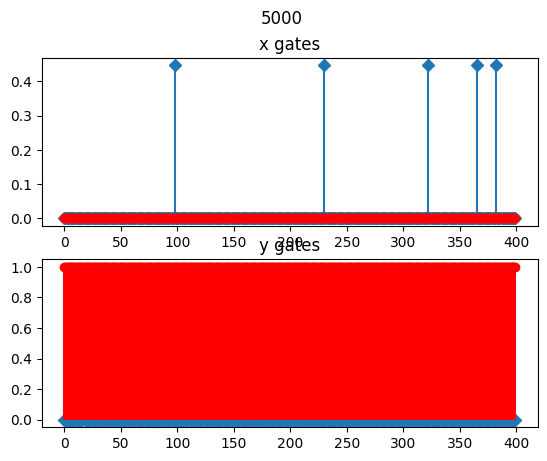

Epoch[5100/10000]: corr: 0.8118, reg: 28844.8066
Epoch[5200/10000]: corr: 0.0000, reg: 28844.1738
Epoch[5300/10000]: corr: 0.0000, reg: 28843.5371
Epoch[5400/10000]: corr: 0.0000, reg: 28842.9355
Epoch[5500/10000]: corr: 0.0000, reg: 28842.3672
Epoch[5600/10000]: corr: 0.0000, reg: 28841.8281
Epoch[5700/10000]: corr: 0.0000, reg: 28841.4102
Epoch[5800/10000]: corr: 0.0000, reg: 28840.9336
Epoch[5900/10000]: corr: 0.0000, reg: 28840.4727
Epoch[6000/10000]: corr: 0.0000, reg: 28840.0371


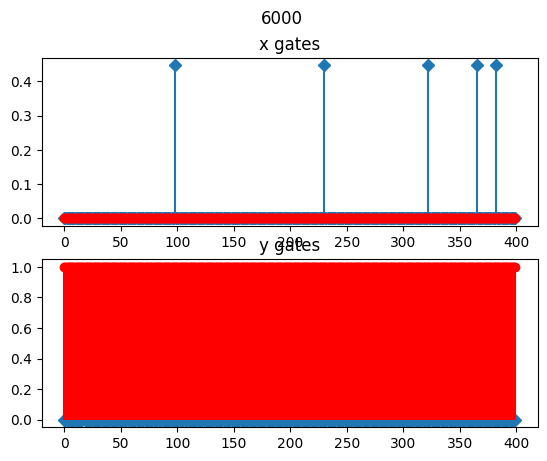

Epoch[6100/10000]: corr: 0.0000, reg: 28839.6211
Epoch[6200/10000]: corr: 0.9135, reg: 28839.2266
Epoch[6300/10000]: corr: 0.0000, reg: 28838.8535
Epoch[6400/10000]: corr: 0.0000, reg: 28838.5020
Epoch[6500/10000]: corr: 0.0000, reg: 28838.1621
Epoch[6600/10000]: corr: 0.0000, reg: 28837.8652
Epoch[6700/10000]: corr: 0.0000, reg: 28837.5566
Epoch[6800/10000]: corr: 0.0000, reg: 28837.2617
Epoch[6900/10000]: corr: 0.0000, reg: 28836.9785
Epoch[7000/10000]: corr: 0.0000, reg: 28836.7109


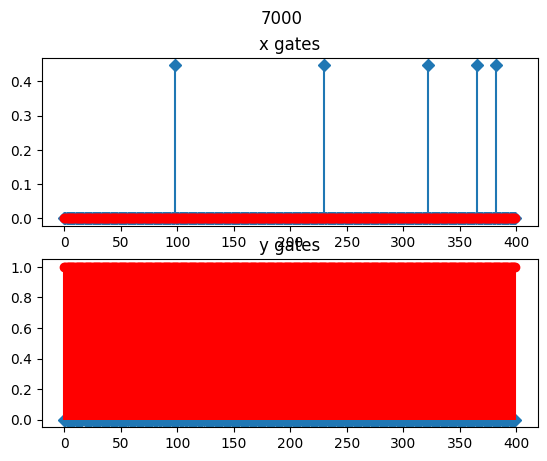

Epoch[7100/10000]: corr: 0.0000, reg: 28836.4551
Epoch[7200/10000]: corr: 0.0000, reg: 28836.2090
Epoch[7300/10000]: corr: 0.0000, reg: 28835.9746
Epoch[7400/10000]: corr: 0.0000, reg: 28835.7520
Epoch[7500/10000]: corr: 0.0000, reg: 28835.5371
Epoch[7600/10000]: corr: 0.7277, reg: 28835.3320
Epoch[7700/10000]: corr: 0.6199, reg: 28835.1367
Epoch[7800/10000]: corr: 0.0000, reg: 28834.9648
Epoch[7900/10000]: corr: 0.0000, reg: 28834.7969
Epoch[8000/10000]: corr: 0.0000, reg: 28834.6250


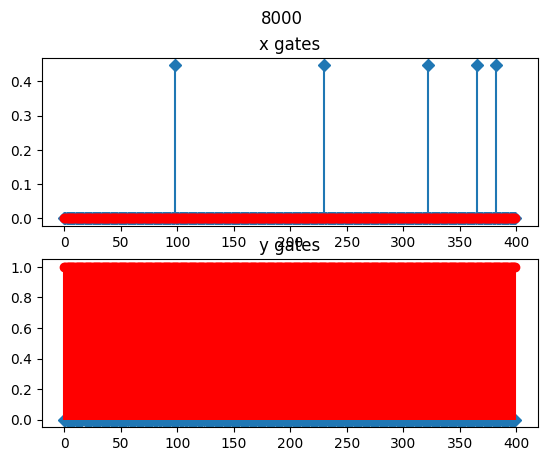

Epoch[8100/10000]: corr: 0.0000, reg: 28834.4590
Epoch[8200/10000]: corr: 0.0000, reg: 28834.3008
Epoch[8300/10000]: corr: 0.0000, reg: 28834.1484
Epoch[8400/10000]: corr: 0.0000, reg: 28834.0020
Epoch[8500/10000]: corr: 0.0000, reg: 28833.8613
Epoch[8600/10000]: corr: 0.0000, reg: 28833.7266
Epoch[8700/10000]: corr: 0.0000, reg: 28833.5977
Epoch[8800/10000]: corr: 0.0000, reg: 28833.4727
Epoch[8900/10000]: corr: 0.0000, reg: 28833.3516
Epoch[9000/10000]: corr: 0.0000, reg: 28833.2363


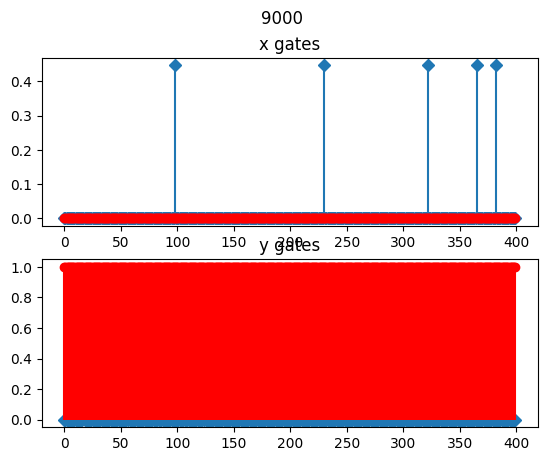

Epoch[9100/10000]: corr: 0.0000, reg: 28833.1484
Epoch[9200/10000]: corr: 0.0000, reg: 28833.0410
Epoch[9300/10000]: corr: 0.0000, reg: 28832.9375
Epoch[9400/10000]: corr: 0.0000, reg: 28832.8379
Epoch[9500/10000]: corr: 0.0000, reg: 28832.7402
Epoch[9600/10000]: corr: 0.0000, reg: 28832.6484
Epoch[9700/10000]: corr: 0.0000, reg: 28832.5586
Epoch[9800/10000]: corr: 0.0000, reg: 28832.4727
Epoch[9900/10000]: corr: 0.0000, reg: 28832.3906
Epoch[10000/10000]: corr: 0.0000, reg: 28832.3105


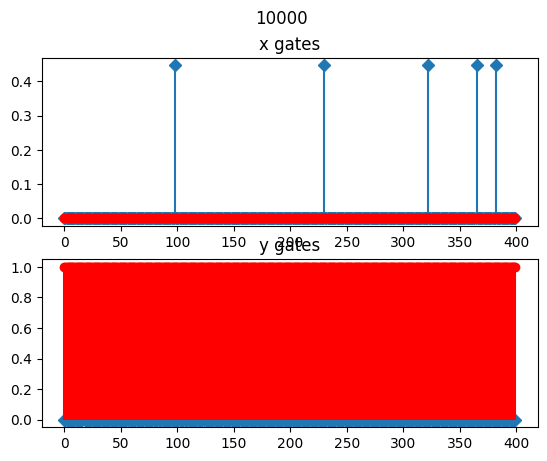

ValueError: shapes (400,1) and (400,) not aligned: 1 (dim 1) != 400 (dim 0)

In [ ]:
import torch
import torch.optim as optim
import numpy as np

def final_run_chosen_params():
    """
    Single-run training with specific hyperparameters + gating plots every 1000 epochs.
    """

    # ========== 1) Hard-code your chosen hyperparams from trial #23 (example) ==========
    lamx    = 72.07478917644063
    lamy    = lamx  # or set lamy explicitly if desired
    sigmax  = 0.3359306773255034
    sigmay  = 0.16908335013155165
    lr_gates= 0.004237579631381151
    lr_func = 3.577682126914971e-05
    K       = 2

    # ========== 2) Generate data with samples=800, size=400 ==========
    samples = 800
    size    = 400
    x_data, y_data, u, v, _ = gen_data(samples, size, size)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    x = torch.tensor(x_data, device=device, dtype=torch.float32)
    y = torch.tensor(y_data, device=device, dtype=torch.float32)

    # ========== 3) Build net with hidden layers [1600, 1600, 400] ==========
    net = create_networks(
        lamx=lamx, sigmax=sigmax,
        lamy=lamy, sigmay=sigmay,
        size=size,
        hidden_layer_sizes=[1600, 1600, 400]  # per your request
    ).to(device)

    criterion = NegCorr(device)
    gates_optimizer = optim.Adam(net.get_gates_parameters(), lr=lr_gates)
    funcs_optimizer = optim.Adam(net.get_function_parameters(), lr=lr_func)

    # ========== 4) Training loop with prints and gating plots ==========
    epochs = 10000  # choose how many you like (1000, 5000, 50000, etc.)

    for epoch in range(epochs):
        neg_corr, reg = train(
            net,
            criterion,
            x,
            y,
            gates_optimizer,
            funcs_optimizer,
            (epoch + 1) % K
        )
        # Print every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f"Epoch[{epoch+1}/{epochs}]: corr: {-neg_corr:.4f}, reg: {reg:.4f}")

        # Plot gates every 1000 epochs
        if (epoch + 1) % 1000 == 0:
            # We assume you have a function 'plot_gates(net, epoch, u, v)' in your code
            plot_gates(net, epoch + 1, u, v)

    # ========== 5) Evaluate final result numerically ==========
    eta_x_est, eta_y_est = net.get_eta_estimate()
    eta_x_est = eta_x_est.detach().cpu().numpy().flatten()
    eta_y_est = eta_y_est.detach().cpu().numpy().flatten()

    # Compare to ground truth
    u_norm = u / (np.linalg.norm(u) + 1e-12)
    v_norm = v / (np.linalg.norm(v) + 1e-12)

    # In your final evaluation
    eta_x_est_norm = eta_x_est / (np.linalg.norm(eta_x_est) + 1e-12)
    eta_y_est_norm = eta_y_est / (np.linalg.norm(eta_y_est) + 1e-12)

    # Actually use the normalized estimates for the dot product:
    dot_x = np.dot(u_norm, eta_x_est_norm)
    dot_y = np.dot(v_norm, eta_y_est_norm)

    error_x = 2.0 * (1.0 - abs(dot_x))
    error_y = 2.0 * (1.0 - abs(dot_y))
    final_error = (error_x + error_y) / 2.0


    # Print summary
    print("\n===== Final Results =====")
    print(f"Correlation: {-neg_corr:.4f}")  # because neg_corr is negative correlation
    print(f"dot_x={dot_x:.4f}, dot_y={dot_y:.4f}")
    print(f"error_x={error_x:.4f}, error_y={error_y:.4f}, final_error={final_error:.4f}")

    return final_error


if __name__ == "__main__":
    final_err = final_run_chosen_params()
    print(f"Single-run final error: {final_err:.4f}")
